# Lateral diffusion of lipids in lipid membranes

We will calculate the diffusion coefficient of lipids in a ternary mixture of DPPC, DOPC, and Cholesterol simulated by [Smith et al.](https://www.biorxiv.org/content/10.1101/2021.05.24.445501v3).

The class `lipyphilic.lib.lateral_diffusion.MSD` can be used to calculate the two-dimensional mean squared displacent (MSD) of lipids in a bilayer. The [Fast Correlation Algorithm](https://www.sciencedirect.com/science/article/pii/001046559500048K), implemented in [tidynamics](http://lab.pdebuyl.be/tidynamics), is used to calculate the MSD of each lipid. From the MSD, we will also calculate the lateral diffusion coefficient of each lipid species.


In [18]:
import pathlib
import pickle

import numpy as np
import matplotlib.pyplot as plt

import MDAnalysis as mda
import tidynamics

from lipyphilic.transformations import nojump
from lipyphilic.lib.lateral_diffusion import MSD


## Load the topology and trajectory using MDAnalysis

In [2]:
u = mda.Universe("../datafiles/dppc-dopc-chol.tpr", "../datafiles/dppc-dopc-chol.xtc")

## Apply "nojump" unwrapping to atomic coordinates
Before using `lipyphilic.lib.lateral_diffusion.MSD`, we **must** ensure that the coordinates have been unwrapped such that no atom is wrapped back into the unit cell after crossing a periodic boundary.

We will use **lipyphilic**'s [on-the-fly](https://www.mdanalysis.org/2020/03/09/on-the-fly-transformations/) nojump transformation to perform this unwrapping.

We must first decide which atoms we would like to be unwrapped.

We will select the 'GL1', 'GL2', and 'ROH' beads, as we will later use these beads for calculating the diffusion coefficient of the lipids.



In [3]:
ag = u.select_atoms("name GL1 GL2 ROH")

We then add the no jump transformation to our universe, specifying we would like the $x$ and $y$ coordinates unwrapped whilst leaving the $z$ coordinates unchanged:

In [5]:
u.trajectory.add_transformations(
    nojump(
        ag=ag,
        nojump_x=True,
        nojump_y=True,
        nojump_z=False)
)


Calculating nojump translation vectors:   0%|          | 0/50 [00:00<?, ?it/s]

Upon adding this transformation to our trajectory, **lipyphilic** will determine the frames at which each atom crosses a boundary, keeping a record of the net movement of each atom across each boundary. In this way, the translation required to move an atom from its wrapped to unwrapped coordainte is calculated for each frame.

Once the translation vectors are known, every time a new frame is loaded into memory by `MDAnalysis` (such as when we iterate over the trajectory) the transformation is applied to unwrap the coordinates.

The are **two benefits** to using this transformation rather than, for example, creating an unwrapped trajectory with GROMACS:

- there is no need to create a second trajectory file - the coordinates are modified in place as each frame is loaded into memory

- the unwrapping scheme employed here accounts for fluctuations in box size in NPT simulations. Failing to properly account for these fluctuations can lead to overestimations of the diffusion coefficient.

### See also

See the [pre-print describing lipyphilic](https://www.biorxiv.org/content/10.1101/2021.05.04.442445v1) for further information on the unwrapping algorithm, and see [von Bülow et al.](https://aip.scitation.org/doi/full/10.1063/5.0008316) for further discussion on pitfalls that arise when box size fluctuations are not accounted for when unwrapping trajectory coordinates.


## Calculate the mean-squared displacement

The lateral mean-square displacement of a lipid is calculated as:
$$
\Bigg\langle \frac{1}{N} \sum_{i=1}^{N} \left  | r_i(t_0 + \Delta t) - r_i(t_0) \right |^2 \displaystyle \Bigg\rangle_{t_0}
$$

where $N$ is the number of lipids, $r_i(t0)$ is the center of mass in $xy$ of lipids $i$ at a time origin $t_0$, $r_i(t0 + \Delta t)$ is the same lipid's center of mass at a lagtime $\Delta t$. The sum is over all lipids, and the angular brackets denote an average over all time origins, $t_0$.

The Fast Correlation Algorithm will use each frame (except the last) as a time origin. That is, if we have 10 frame, there will be 9 different time origins. Multiple time origins are used in order to improve statistics. 

We are now ready to use the class `lipyphilic.lib.lateral_diffusion.MSD` to calculate the MSD of each lipid:


In [7]:
msd = MSD(
    universe=u,
    lipid_sel="name GL1 GL2 ROH",
    com_removal_sel="name GL1 GL2 ROH"
)


Here, our selection 'name GL1 GL2 ROH' specifies that the MSD of lipids will be calculated using these atoms. Specifically:

- the MSD of each phosphoslipid will be calculated using the center of mass of it GL1 and GL2 beads (which corrspond to the glycerol backbone)
- the MSD of each cholesterol will be calculated using position of its ROH bead (which corresponds to the hydroxyl headgroup)

The `com_removal_sel` specifies that the center of mass motion of all 'GL1', 'GL2', and 'ROH' beads should be subtracted from the motion of each lipid. This is useful to remove any drift of your bilayer in the $xy$ plane.


We then select which frames of the trajectory to analyse (`None` will use every frame) and choose to display a progress bar (`verbose=True`)::
  

In [8]:
msd.run(
    start=None,
    stop=None,
    step=None,
    verbose=True
)
 

  0%|          | 0/51 [00:00<?, ?it/s]

## Accessing the results

The MSD of each lipid is stored in in the `msd.msd` attribute as a two-dimensional NumPy array of shape ($N_{\rm lipids}$, $N_{\rm frames}$). Each row corresponds to an individual lipid and each column to a different lagtime.

There are 12000 rows and 51 columns - one row per lipid and one column per frame:

In [13]:
msd.msd.shape

(12000, 51)

At the first frame, the MSD of every lipid is equal to zero:

In [16]:
all(msd.msd.T[0] == 0)

True

Now we have the MSD of each lipid,we can calculate the lateral diffusion coefficient of each species.

# Calculating the diffusion coefficient

The lateral diffusion is calculated as:

$$
D_{xy} = \frac{1}{4} \lim_{t\to\infty} \frac{d}{dt} \rm{MSD}_{xy}
$$

where $\rm{MSD}_{xy}$ is given by a the slope of a linear fit to our MSD curve.


## Plotting the MSD curve for each species

In [21]:
# create a residue group that can be used for filter the MSD results
membrane = u.select_atoms("name GL1 GL2 ROH").residues


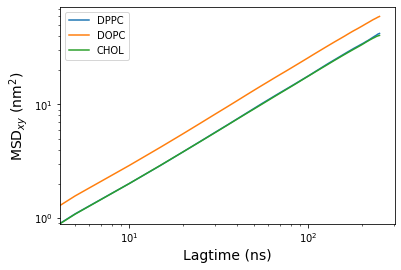

In [31]:
for species in ["DPPC", "DOPC", "CHOL"]:
    
    # create a boolean mask for filterin out the current species
    species_mask = (membrane.residues.resnames == species)
    
    # select the msd of the current species
    species_msd = msd.msd[species_mask]  # this contains the msd of each lipid molecule of the relevant species
    
    # get the mean MSD for the species
    mean_species_msd = np.mean(species_msd, axis=0)
    
    # Plot the MSD against lagtime
    plt.loglog(
        msd.lagtimes,
        mean_species_msd,
        label=species
    )

plt.xlabel("Lagtime (ns)", fontsize=14)
plt.ylabel(r"MSD$_{xy}\ \rm{(nm^2)}$", fontsize=14)

plt.legend()


### Note

Typically, an MSD curve would have two regimes - a subdiffuse regime at small lagtimes (< 10s ns) and a diffusive regime at larger lagtimes (> 10s ns). As we are using a trajectory with 5 ns intervals between frames, we do not capture the subdiffusive regime.



## Calculate the diffusion coefficient all lipids

`MSD` has a helper function called `diffusion_coefficient` that we can use to calculate the lateral diffusion coefficient of all selected lipids:


In [32]:
d, sem  = msd.diffusion_coefficient()

This function calculates a diffusion coefficient for each individual lipid, and return the mean and standard error of the distribution of coefficients.


In [43]:
print(f"mean: {d:.2}, sem: {sem:.2}")

mean: 4.8e-07, sem: 1.1e-08


## Specifiy the region of the MSD curve to use for calculating the diffusion coefficient

By default, the diffusion coefficient will be calculated by fitting a straight line to the central part of the MSD curve, ignoring the smallest largest lagtimes (specifically, lagtimes from the 20th to 80th percentile are used.)

Alternatively, we can specificy the period we would like to fit the curve to using the `start_fit` and `stop_fit` keywords:


In [44]:
d, sem  = msd.diffusion_coefficient(
    start_fit=100,  # start fitting from a lagtime of 100 ns
    stop_fit=200    # stop fitting from a lagtime of 200 ns
)


## Calculate the diffusion coefficient of each species

We can calculate the diffusion for each lipid species by passing an atom selection to the `lipid_sel` keyword of `diffusion_coefficient`:


In [47]:
for species in ["DPPC", "DOPC", "CHOL"]:
    
    d, sem = msd.diffusion_coefficient(
        start_fit=100,
        stop_fit=200,
        lipid_sel=f"resname {species}"
    )
    
    print(f"species: {species}, mean: {d:.2}, sem: {sem:.2}")


species: DPPC, mean: 4.1e-07, sem: 1.8e-08
species: DOPC, mean: 5.9e-07, sem: 2.3e-08
species: CHOL, mean: 4e-07, sem: 2e-08


We see that DOPC has the largest diffusion coefficient of the three species.

